# 1. Build your own convolutional neural network using p

In [1]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn

# Residual Block Definition
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  # BatchNorm
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection for residual learning
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

# CNN Model with 5 Convolutional Layers (including Residuals)
class DogHeartCNN5(nn.Module):
    def __init__(self):
        super(DogHeartCNN5, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # 128x128 -> 128x128
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 128x128 -> 64x64

            ResidualBlock(32, 64, stride=2),  # Downsample 64x64 -> 32x32
            ResidualBlock(64, 64),  # 32x32 -> 32x32

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 32x32 -> 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16

            ResidualBlock(128, 256, stride=2),  # Downsample 16x16 -> 8x8
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # 8x8 -> 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8 -> 4x4

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # Additional layer
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 4x4 -> 2x2
        )

        # Adaptive Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)  # Output: 512x1x1

        # Fully Connected Layers
        self.fc_layers = nn.Sequential(
            nn.Linear(512, 512),  # Input 512 from GAP
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),      # Dropout for regularization
            nn.Linear(512, 3)     # Trinary classification (3 classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.gap(x)  # Global Average Pooling
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 512)
        x = self.fc_layers(x)
        return x

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the transformations
train_transform = transforms.Compose([
    transforms.Resize((128, 128)), # Random crop and resize to 128x128
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    #transforms.RandomRotation(20),     # Random rotation between -20 and 20 degrees
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color adjustments
    transforms.ToTensor(),             # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet values
])

valid_transform = transforms.Compose([
    transforms.Resize(128),            # Resize image to 128x128
    transforms.CenterCrop(128),        # Crop the center of the image to 128x128
    transforms.ToTensor(),             # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet values
])

# Load training and validation datasets
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Dog_heart/Train', transform=train_transform)
valid_dataset = datasets.ImageFolder('/content/drive/MyDrive/Dog_heart/Valid', transform=valid_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Print class names to verify
print("Classes:", train_dataset.classes)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Classes: ['Large', 'Normal', 'Small']


In [4]:
import torch.optim as optim

# Initialize model, loss function, and optimizer
model = DogHeartCNN5().to(device)
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function with validation
def train_and_validate(model, train_loader, valid_loader, criterion, optimizer, epochs=100):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        model.train()  # Set model to training mode

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        # Calculate average loss for this epoch
        train_loss = running_loss / len(train_loader.dataset)

        # Validate the model
        valid_loss, valid_accuracy = validate_model(model, valid_loader, criterion)

        print(f"Epoch [{epoch + 1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Validation Loss: {valid_loss:.4f}, "
              f"Validation Accuracy: {valid_accuracy:.2f}%")

# Validation function
def validate_model(model, valid_loader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(valid_loader.dataset)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# 2. Train your model using dog heart dataset (you may need to use  Google Colab (or Kaggle) with GPU to train your code)

### (1) use torchvision.datasets.ImageFolder for the training dataset
### (2) use custom dataloader for test dataset (return image tensor and file name)

In [5]:
# Train and validate the model
train_and_validate(model, train_loader, valid_loader, criterion, optimizer, epochs=100)

# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/dogheart_cnn5_multiclass.pth')

Epoch [1/100], Train Loss: 1.0493, Validation Loss: 0.8863, Validation Accuracy: 55.00%
Epoch [2/100], Train Loss: 0.8614, Validation Loss: 0.7544, Validation Accuracy: 63.50%
Epoch [3/100], Train Loss: 0.7663, Validation Loss: 1.2494, Validation Accuracy: 45.00%
Epoch [4/100], Train Loss: 0.7065, Validation Loss: 0.6495, Validation Accuracy: 68.50%
Epoch [5/100], Train Loss: 0.6673, Validation Loss: 0.7261, Validation Accuracy: 67.50%
Epoch [6/100], Train Loss: 0.6475, Validation Loss: 0.6727, Validation Accuracy: 63.50%
Epoch [7/100], Train Loss: 0.6003, Validation Loss: 0.9476, Validation Accuracy: 64.00%
Epoch [8/100], Train Loss: 0.6583, Validation Loss: 0.6930, Validation Accuracy: 68.50%
Epoch [9/100], Train Loss: 0.6054, Validation Loss: 0.7618, Validation Accuracy: 62.50%
Epoch [10/100], Train Loss: 0.5802, Validation Loss: 0.7882, Validation Accuracy: 65.50%
Epoch [11/100], Train Loss: 0.5494, Validation Loss: 0.9134, Validation Accuracy: 58.50%
Epoch [12/100], Train Loss: 0.

In [12]:
# 3. Evaluate your model using the developed software
import os
from PIL import Image  # Import this at the top of your script
import pandas as pd
import csv
# Now you can use Image.open() to load images

# Define numeric class labels
class_labels = ['Large', 'Normal', 'Small']  # 0 -> Large, 1 -> Normal, 2 -> Small
label_mapping = {0: 'Large', 1: 'Normal', 2: 'Small'}

# Define a custom test dataset and DataLoader
test_dir = '/content/drive/MyDrive/Test'  # Replace with your test directory
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class CustomTestDataset(torch.utils.data.Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = [f for f in os.listdir(directory) if f.endswith('.jpg') or f.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.images[idx])
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, self.images[idx]

test_dataset = CustomTestDataset(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Make predictions and save to CSV
predictions = []

model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, filenames in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get class predictions for the batch

        # Loop through the batch and store predictions for each image
        for i in range(len(filenames)):
            predicted_label = predicted[i].item()  # Get the prediction for each image in the batch
            predicted_class = label_mapping[predicted_label]

            # Save predictions
            predictions.append([filenames[i], predicted_label])  # Save filename and numeric label

            #print(f"Image: {filenames[i]} - Predicted Label: {predicted_label} ({predicted_class})")

# Save predictions to a CSV file
results_df = pd.DataFrame(predictions, columns=["Filename", "Predicted Label"])
results_df.to_csv('/content/drive/MyDrive/predictionsCNN5.csv', index=False, header=False)
print("Predictions saved to predictionsCNN5.csv")

Predictions saved to predictionsCNN5.csv


# 3. Evaluate your model using the developed software

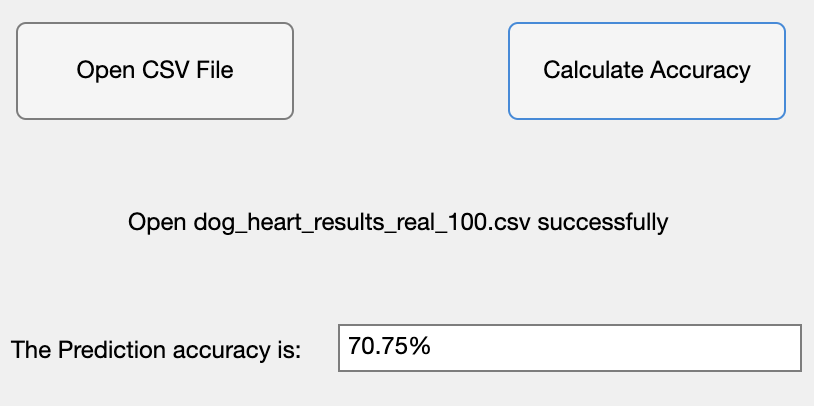)

# 4. Compare results with [RVT paper](https://www.nature.com/articles/s41598-023-50063-x). Requirement: performance is better than VGG16: 75%

I am getting accuracy of 70.75%

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link and GitHub weight link here.



https://www.researchgate.net/publication/385945663_Evaluating_Cardiomegaly_in_Dogs_Using_a_CNN_Model

https://github.com/ankita130698/Cardiomegaly-in-Dogs-Using-a-CNN-Model/blob/main/dog_heart_model_100.pth